In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
import matplotlib.colors as cm
import utils_PLS as upls

volumes = ace.clean_volumes_database()

root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'Black_wf_WholeBrain'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]

def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells_' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

thresholds = [500, 1500, 2500, 3500, 4500, 5500, 6500]

In [3]:
subjects = ['BL45Control', 'BL51Control', 'BL53Control',
           'BL47Fam', 'BL49Fam', 'BL50Fam']
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels = ['Control', 'Fam'])
experimental_groups

{'Control': ['BL45Control', 'BL51Control', 'BL53Control'],
 'Fam': ['BL47Fam', 'BL49Fam', 'BL50Fam']}

In [4]:
def sum_values(subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        data[metric] = [pd.read_csv(
            data_directory+subject+'/'+subject+str(threshold)+'.csv')[metric].sum() \
                        for subject in subjects for threshold in thresholds]
    return data


In [5]:
def plot_values(data, palette='Set2'):
    fig, axes = plt.subplots(2,2, figsize=(10,10))
    plt.subplots_adjust(hspace=0.06)
    sns.lineplot(data=data, x='subject', y='n_cells', hue='threshold', ax=axes[0][0], legend=False, 
                 palette=palette, marker="o")
    axes[0][0].tick_params(labelbottom=False) 
    axes[0][0].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='energy', hue='threshold', ax=axes[0][1], 
                 palette=palette, marker="o")
    axes[0][1].legend().set_title('')
    axes[0][1].tick_params(labelbottom=False)
    axes[0][1].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='density', hue='threshold', ax=axes[1][0], legend=False, 
                 palette=palette, marker="o")
    axes[1][0].tick_params(axis='x', rotation=90)
    axes[1][0].set_xlabel('')

    sns.lineplot(data=data, x='subject', y='relative_density', hue='threshold', ax=axes[1][1], legend=False, 
                 palette=palette, marker="o")
    axes[1][1].tick_params(axis='x', rotation=90)
    axes[1][1].set_xlabel('')

In [6]:
def find_significant_areas(dictionary, experimental_groups, groups=['Control', 'Fam', 'Unfam'],test='mannwhitneyu'):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value='n_cells')
    df_ttest = ace.test_across_groups(dfs,
                                      groups=groups,
                                     test=test)
    # remove rows corresponding to area that have zero cell count across all experimental groups
#     df_ttest = df_ttest.dropna(axis=0,
#                                how='all',
#                                subset=['pval_Control_vs_Fam',
#                                        'pval_Control_vs_Unfam',
#                                        'pval_Fam_vs_Unfam'])
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<0.05]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [7]:
def calculate_ratio_detected_cells(subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells_analysis', 'n_detected_cells', 'ratio'])
    data_sum = sum_values(subjects=subjects, thresholds=thresholds)
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]

    n_cells = []
    n_detected_cells = []
    ratio = []
    for subject in subjects:
        for threshold in thresholds:
            sum_n = data_sum[(data_sum['subject']==subject) & 
                                    (data_sum['threshold']==threshold)]['n_cells'].item()
            n_cells.append(sum_n)
            det_n = len(pd.read_csv(data_directory+subject+'/cells_'+str(threshold)+'.csv',
                                                   low_memory=False))
            n_detected_cells.append(det_n)
            ratio.append(sum_n/det_n)


    data['n_cells_analysis'] = n_cells
    data['n_detected_cells'] = n_detected_cells
    data['ratio'] = ratio
    return data

In [8]:
def dataframe_areas(area, subjects, thresholds):
    data = pd.DataFrame(columns=['subject', 'threshold', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects for threshold in thresholds]
    data['threshold'] = [threshold for subject in subjects for threshold in thresholds]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        values = []
        for subject in subjects:
            for threshold in thresholds:
                v = pd.read_csv(data_directory+subject+'/'+subject+str(threshold)+'.csv')
                values.append(v[v['area']==area][metric].values[0])
        data[metric] = [v for v in values]
    return data


# Plot ratio of detected cells over cells used for analysis

In [9]:
ratio = calculate_ratio_detected_cells(subjects=subjects, 
                                       thresholds=thresholds)

In [10]:
ratio

,subject,threshold,n_cells_analysis,n_detected_cells,ratio
0,BL45Control,500,2754149,4829076,0.570326
1,BL45Control,1500,407761,681418,0.598401
2,BL45Control,2500,164456,274840,0.598370
3,BL45Control,3500,97499,152860,0.637832
4,BL45Control,4500,61322,95211,0.644064
5,BL45Control,5500,41311,63658,0.648952
6,BL45Control,6500,29101,44545,0.653294
7,BL51Control,500,2530256,4161972,0.607946
8,BL51Control,1500,423474,709017,0.597269
9,BL51Control,2500,183728,302724,0.606916


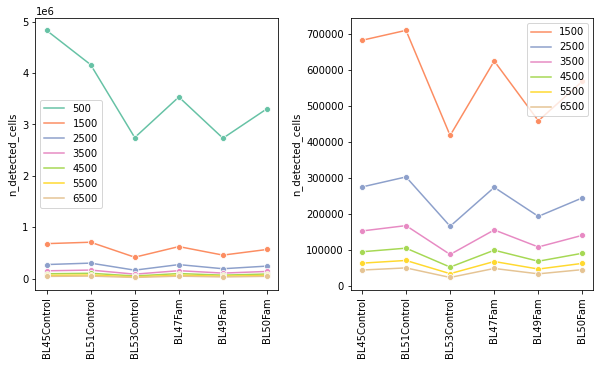

In [11]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.lineplot(data=ratio, x='subject', y='n_detected_cells', hue='threshold', ax=axes[0], 
             legend=True, palette='Set2', marker="o")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].legend().set_title('')

cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
sns.lineplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', hue='threshold', ax=axes[1], legend=True
            , palette=cmap, marker="o")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].legend().set_title('')

Text(0.5, 1.0, 'Excluding threshold 500')

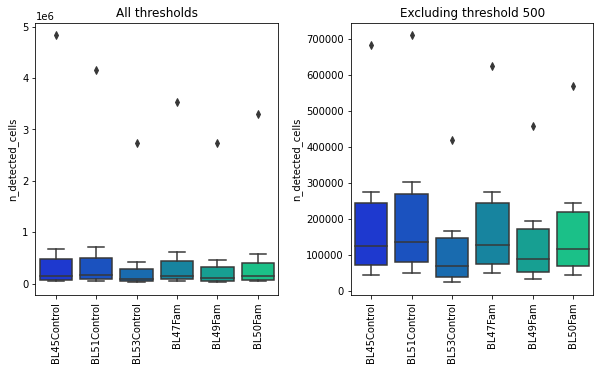

In [12]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='subject', y='n_detected_cells', ax=axes[0], 
             palette='winter')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].set_title('All thresholds')

sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='subject', y='n_detected_cells', ax=axes[1], 
            palette='winter')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].set_title('Excluding threshold 500')

Text(0.5, 0, '')

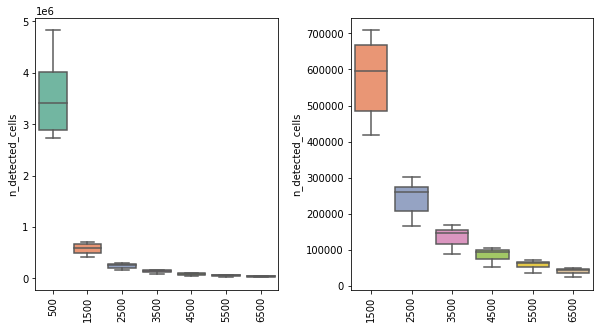

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(wspace=0.3)

sns.boxplot(data=ratio, x='threshold', y='n_detected_cells', ax=axes[0], 
             palette='Set2')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
sns.boxplot(data=ratio[ratio['threshold']!=500], 
             x='threshold', y='n_detected_cells', ax=axes[1], 
            palette=cmap)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')

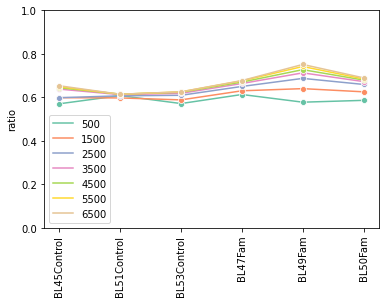

In [14]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.lineplot(data=ratio, x='subject', y='ratio', hue='threshold', ax=axes, legend=True, palette='Set2', marker="o")
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])
plt.gca().legend().set_title('')

(0.0, 1.0)

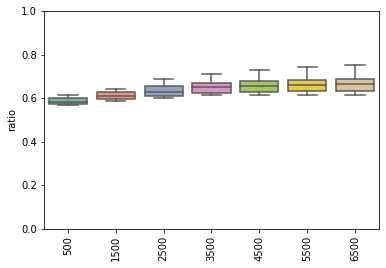

In [15]:
fig, axes = plt.subplots(1,1)
plt.subplots_adjust(hspace=0.06)
sns.boxplot(data=ratio, x='threshold', y='ratio', ax=axes, palette='Set2')
axes.tick_params(axis='x', rotation=90)
axes.set_xlabel('')
axes.set_ylim([0,1])

# Plot total number of cells

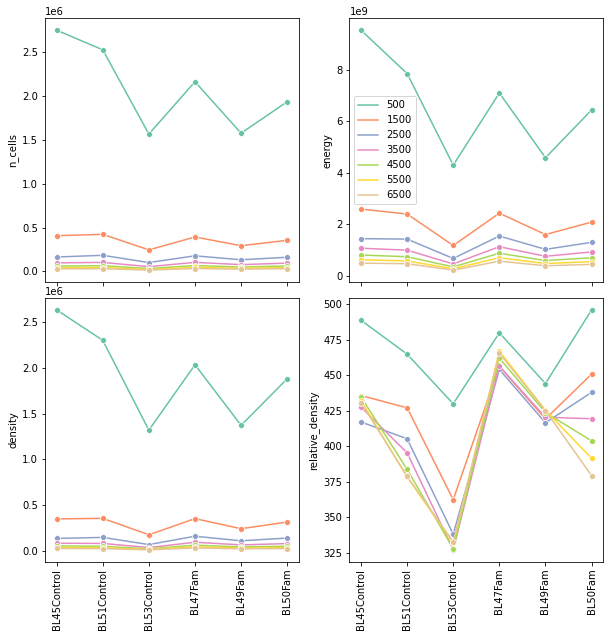

In [16]:
data = sum_values(subjects=subjects, thresholds=thresholds)

plot_values(data)

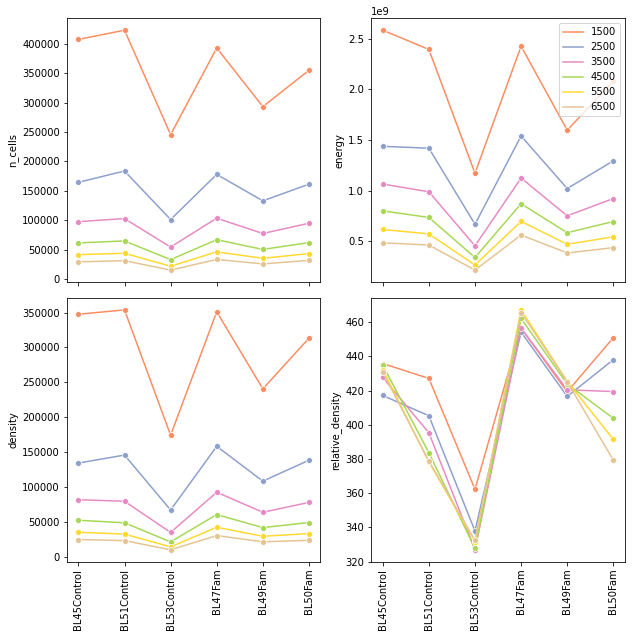

In [17]:
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = sum_values(subjects=subjects, thresholds=thresholds[1:])

plot_values(data, palette=cmap)

# Plot single areas

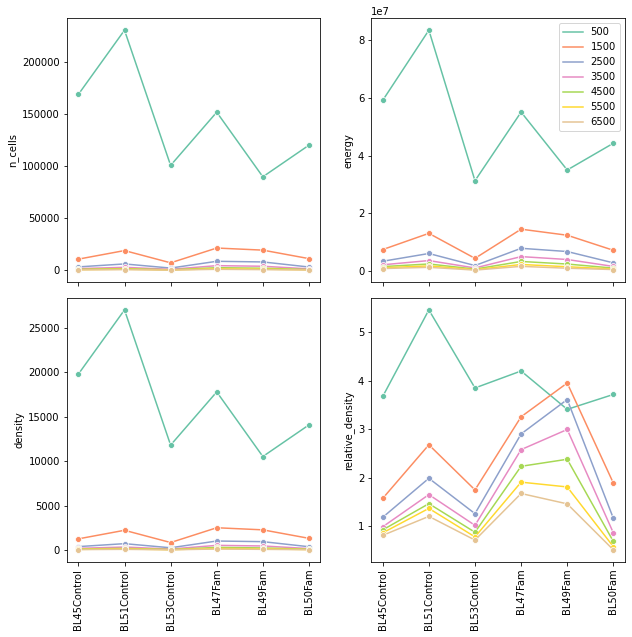

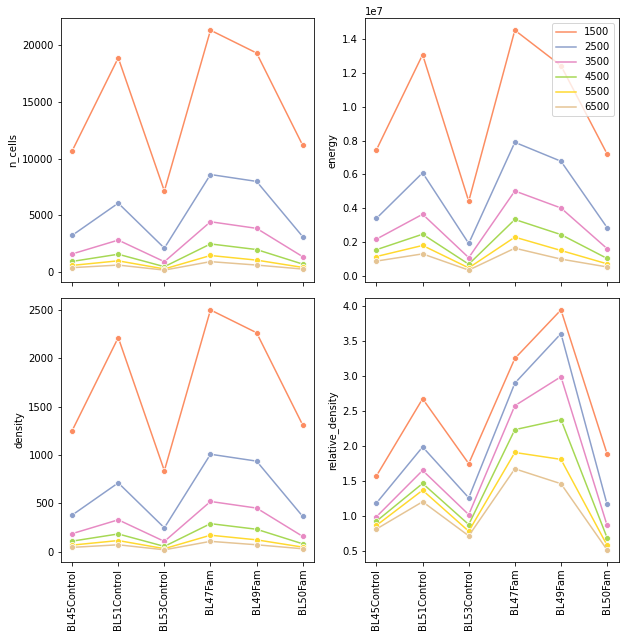

In [20]:
data = dataframe_areas(area="Main olfactory bulb",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Main olfactory bulb",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


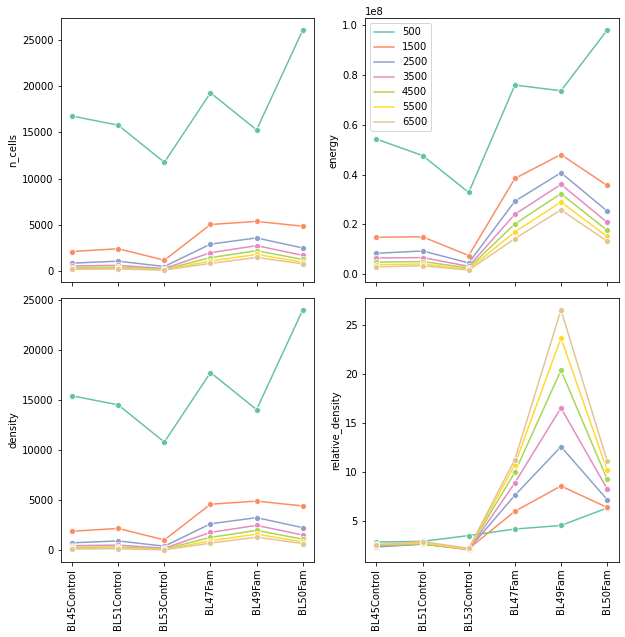

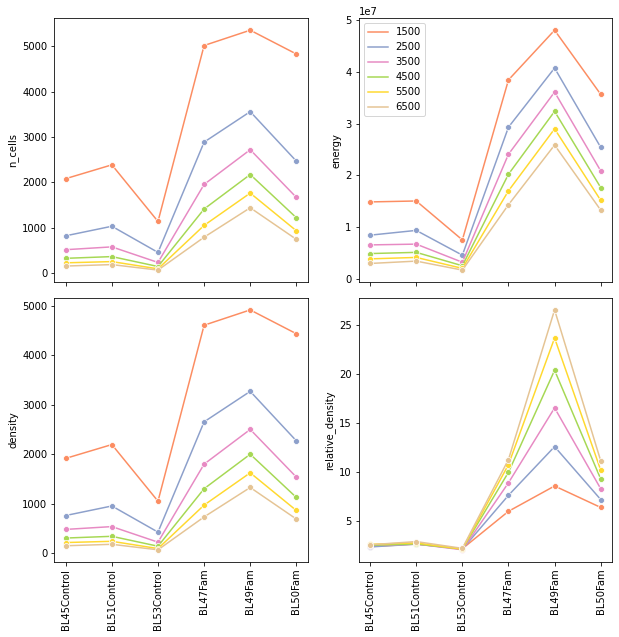

In [21]:
data = dataframe_areas(area="Medial amygdalar nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Medial amygdalar nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


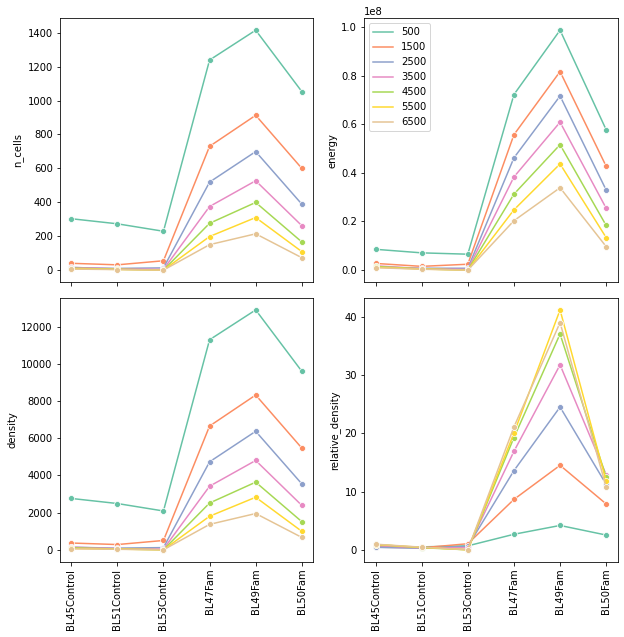

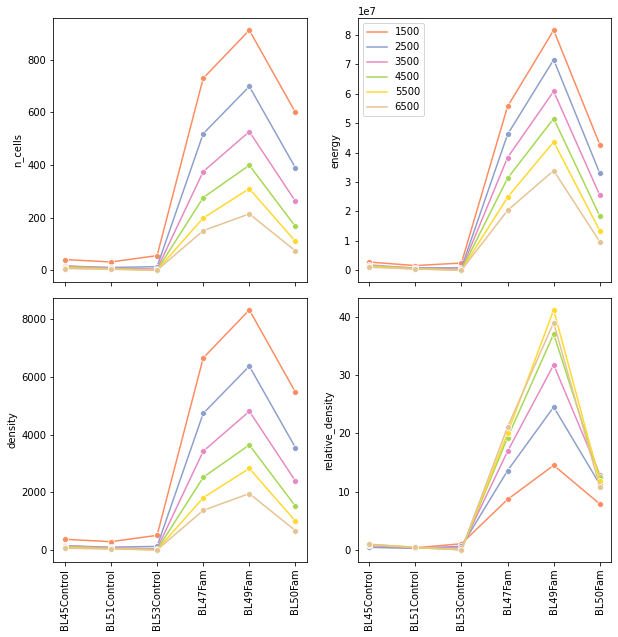

In [22]:
data = dataframe_areas(area="Ventral premammillary nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Ventral premammillary nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


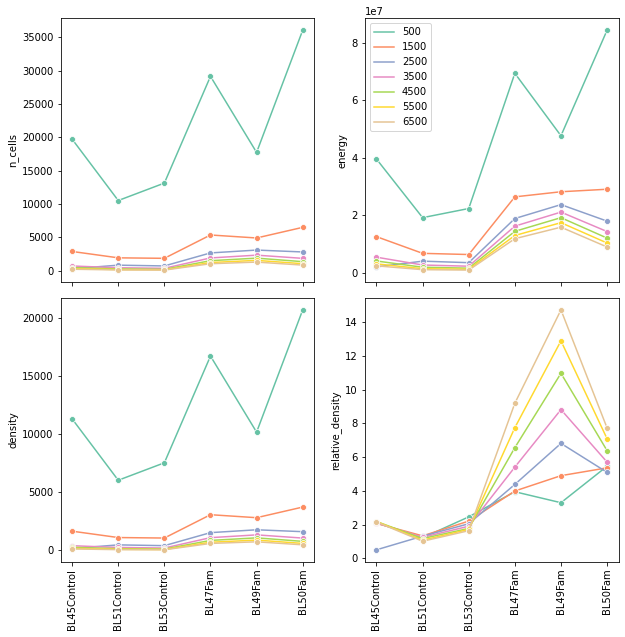

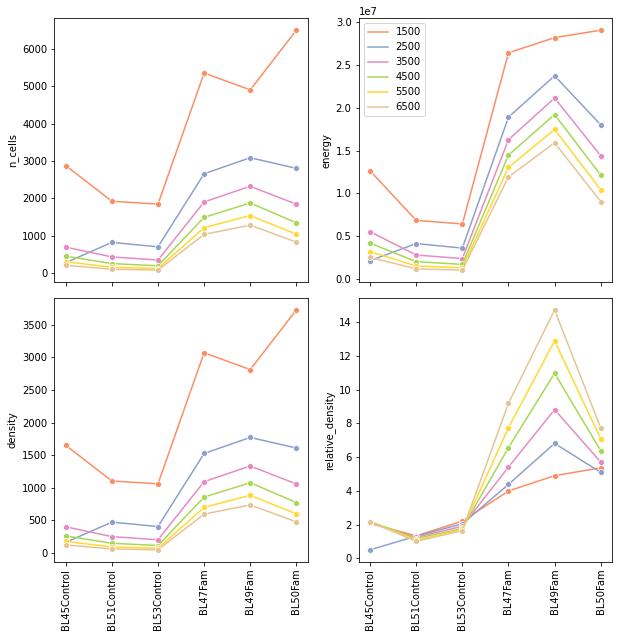

In [23]:
data = dataframe_areas(area="Cortical amygdalar area",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Cortical amygdalar area",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


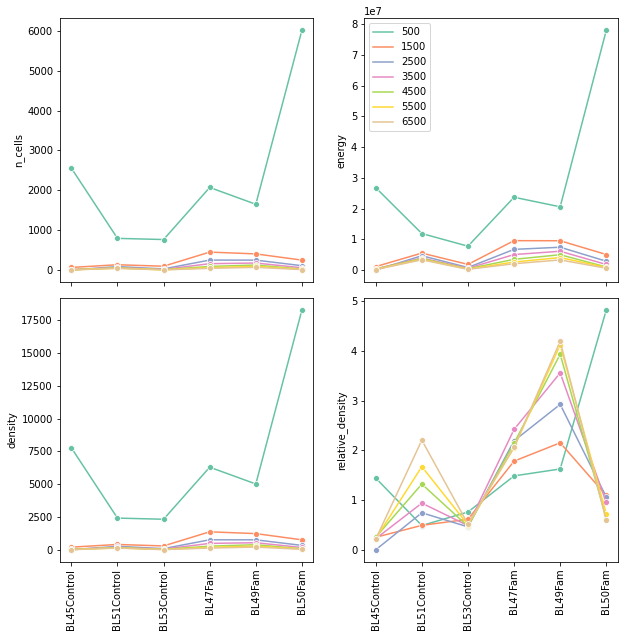

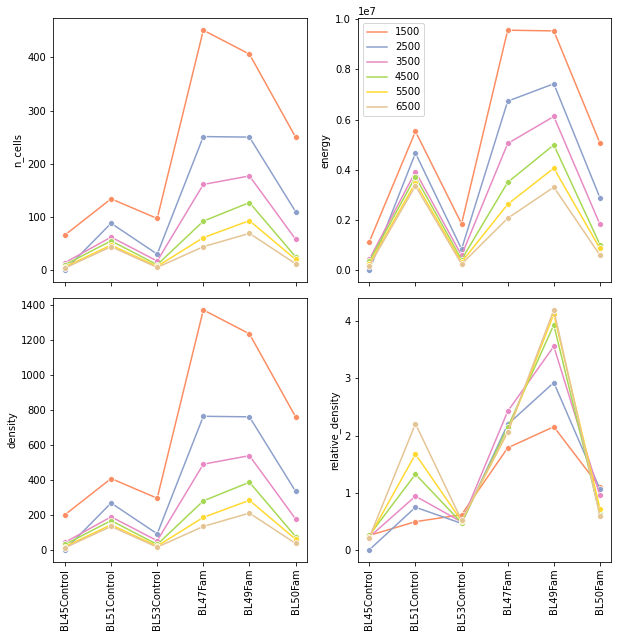

In [24]:
data = dataframe_areas(area="Arcuate hypothalamic nucleus",
                      subjects=subjects,
                      thresholds=thresholds)
plot_values(data)
cmap = [plt.cm.Set2(i) for i in range(1, len(thresholds))]
data = dataframe_areas(area="Arcuate hypothalamic nucleus",
                      subjects=subjects,
                      thresholds=thresholds[1:])
plot_values(data, palette=cmap)


# T-test for mean area activation across groups

In [31]:
dict500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(500)+'.csv')
                            for subject in subjects}
df_sigareas500 = find_significant_areas(dictionary=dict500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas500

,Control_vs_Fam
0,Ventral premammillary nucleus
1,Lateral mammillary nucleus
2,Ventrolateral preoptic nucleus
3,Periventricular hypothalamic nucleus posterior...
4,Intergeniculate leaflet of the lateral genicul...
5,Posterior amygdalar nucleus
6,Rhomboid nucleus


In [32]:
dict1500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(1500)+'.csv')
                            for subject in subjects}
df_sigareas1500 = find_significant_areas(dictionary=dict1500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas1500

,Control_vs_Fam
0,Intercalated amygdalar nucleus
1,Basomedial amygdalar nucleus
2,Parataenial nucleus
3,Parafascicular nucleus
4,Lateral posterior nucleus of the thalamus
5,Arcuate hypothalamic nucleus
6,Posterodorsal preoptic nucleus
7,Periventricular hypothalamic nucleus posterior...
8,Medial amygdalar nucleus
9,Posterior amygdalar nucleus


In [33]:
dict2500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(2500)+'.csv')
                            for subject in subjects}
df_sigareas2500 = find_significant_areas(dictionary=dict2500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas2500

,Control_vs_Fam
0,Posterodorsal preoptic nucleus
1,Vascular organ of the lamina terminalis
2,Piriform-amygdalar area
3,Cortical amygdalar area
4,Tuberomammillary nucleus
5,Endopiriform nucleus
6,Parataenial nucleus
7,Piriform area
8,Nucleus of the lateral olfactory tract
9,Medial amygdalar nucleus


In [34]:
dict3500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(3500)+'.csv')
                            for subject in subjects}
df_sigareas3500 = find_significant_areas(dictionary=dict3500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas3500

,Control_vs_Fam
0,Posterodorsal preoptic nucleus
1,Parafascicular nucleus
2,Piriform-amygdalar area
3,Medial amygdalar nucleus
4,Ventral premammillary nucleus
5,Tuberomammillary nucleus
6,Periventricular hypothalamic nucleus posterior...
7,Posterior hypothalamic nucleus
8,Intercalated amygdalar nucleus
9,Cortical amygdalar area


In [35]:
dict4500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(4500)+'.csv')
                            for subject in subjects}
df_sigareas4500 = find_significant_areas(dictionary=dict4500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas4500

,Control_vs_Fam
0,Subgeniculate nucleus
1,Posterior hypothalamic nucleus
2,Anteroventral periventricular nucleus
3,Cortical amygdalar area
4,Central amygdalar nucleus
5,Endopiriform nucleus
6,Piriform-amygdalar area
7,Agranular insular area
8,Ventral premammillary nucleus
9,Intercalated amygdalar nucleus


In [39]:

dict5500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(5500)+'.csv')
                            for subject in subjects}
df_sigareas5500 = find_significant_areas(dictionary=dict5500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas5500

,Control_vs_Fam
0,Induseum griseum
1,Septohippocampal nucleus
2,Interanteromedial nucleus of the thalamus
3,Subthalamic nucleus
4,Lateral posterior nucleus of the thalamus
5,Anteroventral periventricular nucleus
6,Nucleus of the lateral olfactory tract
7,Cortical amygdalar area
8,Agranular insular area
9,Piriform-amygdalar area


In [40]:
dict6500 = {subject: pd.read_csv(data_directory+subject+'/'+subject+str(6500)+'.csv')
                            for subject in subjects}
df_sigareas6500 = find_significant_areas(dictionary=dict6500,
                                    experimental_groups=experimental_groups,
                                       groups=['Control', 'Fam'])
df_sigareas6500

,Control_vs_Fam
0,Interanteromedial nucleus of the thalamus
1,Periventricular hypothalamic nucleus posterior...
2,Piriform area
3,Nucleus of the lateral olfactory tract
4,Agranular insular area
5,Cortical amygdalar area
6,Piriform-amygdalar area
7,Midbrain reticular nucleus retrorubral area
8,Posterior hypothalamic nucleus
9,Medial amygdalar nucleus


## Find common areas across all thresholds

In [82]:
# common areas in Control_vs_Fam
common_areas = {tag: 
list(set(df_sigareas500[tag].dropna()).intersection(
df_sigareas1500[tag].dropna()).intersection(
df_sigareas2500[tag].dropna()).intersection(
df_sigareas3500[tag].dropna()).intersection(
df_sigareas4500[tag].dropna()))
                for tag in df_sigareas500.columns}
common_areas

{'Control_vs_Fam': ['Posterior amygdalar nucleus',
  'Ventral premammillary nucleus',
  'Periventricular hypothalamic nucleus posterior part']}

## Number of significant areas

In [94]:
number_sig_area = pd.DataFrame(columns=['threshold']+ [col for col in df_sigareas500.columns])
for df, t in zip([df_sigareas500,
                df_sigareas1500,
                df_sigareas2500,
                df_sigareas3500,
                df_sigareas4500,
                df_sigareas5500,
                df_sigareas6500],
                thresholds):
    number_sig_area.loc[len(number_sig_area.index)] = [t, 
                                                       len(df['Control_vs_Fam'].dropna())]

Text(0.5, 0, '')

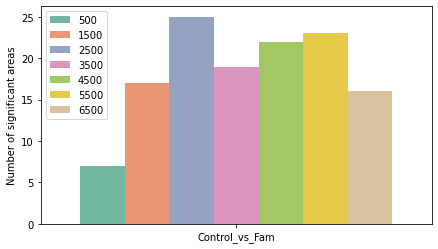

In [95]:
plot_number_sig_area = number_sig_area.set_index('threshold').stack()\
    .reset_index(name='Number of significant areas').rename(columns={'level_1':'group'})

fig, axes = plt.subplots(1,1, figsize=(7,4))
sns.barplot(data=plot_number_sig_area, x='group',
            y='Number of significant areas', hue='threshold', ax=axes, palette='Set2')
axes.legend().set_title('')
axes.set_xlabel('')


## Find common areas across all thresholds

In [42]:
# common areas in Control_vs_Fam
common_areas = {tag: 
list(set(df_sigareas500[tag].dropna()).intersection(
df_sigareas1500[tag].dropna()).intersection(
df_sigareas2500[tag].dropna()).intersection(
df_sigareas3500[tag].dropna()).intersection(
df_sigareas4500[tag].dropna()).intersection(
df_sigareas5500[tag].dropna()).intersection(
df_sigareas6500[tag].dropna())
    )
                for tag in df_sigareas500.columns}
common_areas

{'Control_vs_Fam': ['Ventral premammillary nucleus',
  'Posterior amygdalar nucleus',
  'Periventricular hypothalamic nucleus posterior part']}

# Show correlation matrices

In [57]:
def corr_matrix(experimental_groups,
               dict_results_across_mice,
               value='n_cells'):
    n_groups = len(experimental_groups.keys())
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    # rename areas with acronyms
    for df in dfs:
        for i in df.index:
            df.at[i, 'area'] = volumes[volumes['safe_name'] == \
                                       df.at[i, 'area']]['acronym'].values[0]
    # remove null values
    for df in dfs:
        df = df.set_index('area').loc[
                ~(df.set_index('area')==0).all(axis=1)].dropna(axis=0)
    
    df1, df2 = dfs
    # fix here loop of intersections
    indexes_intersect = df1.index.intersection(df2.index)
    print(indexes_intersect)
    corr_matrices = []
    for df in dfs:
        df = df.loc[indexes_intersect]
        # check here why it is empty
        corr_matrices.append(df.set_index('area').T.corr(method='pearson'))
    return corr_matrices

In [58]:
corr_matrices = [corr_matrix(experimental_groups=experimental_groups,
                           dict_results_across_mice=dictionary) for dictionary in [dict500, 
                                                                                   dict1500,
                                                                                   dict2500,
                                                                                   dict3500,
                                                                                   dict4500,
                                                                                   dict5500,
                                                                                   dict6500]] 

RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)
RangeIndex(start=0, stop=198, step=1)


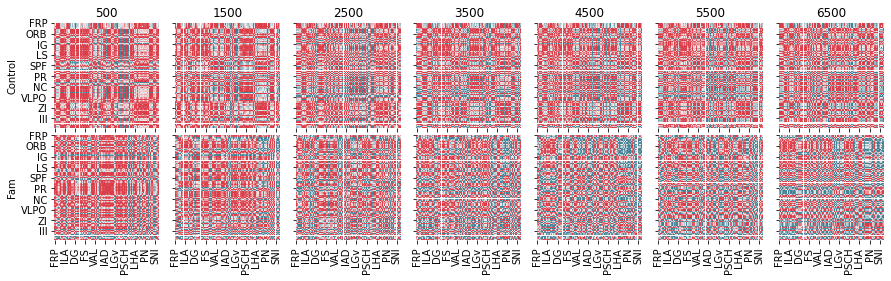

In [60]:
f, ax = plt.subplots(2,7, figsize=(15, 4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.07, wspace=0.07)
group_labels = ['Control', 'Fam']
for i, threshold in enumerate(corr_matrices):
    for j, matrix in enumerate(threshold):
        sns.heatmap(matrix,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0,
        square=True, cbar=False, ax=ax[j][i])
        ax[j][i].set_xlabel('')
        ax[j][i].set_ylabel('') if i!=0 else ax[j][i].set_ylabel(group_labels[j])
        if j==0:
            ax[j][i].set_title(str(thresholds[i]))

# Analysis Task PLS

In [67]:
df_levels = upls.create_df_levels(volumes)
for i, dictionary in enumerate([dict500,dict1500,dict2500,dict3500,dict4500,dict5500,dict6500]):
    dictionary = upls.reformat_dict_acronym(dict_results=dictionary,
                                            volumes=volumes)
    data_relative_density = upls.format_data_pls(dict_results=dictionary, 
                                                 batch='BL_wf_WholeBrain'+str(thresholds[i]), 
                                                 table='relative_density')
    data_relative_density.dropna(inplace=True, axis=1)
    data_relative_density.to_csv('./results_pls/BL_wf_WholeBrain'+str(thresholds[i])\
                                 +'_relative_density.csv')

In [62]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain500_relative_density.csv -o './results_pls/BL_wf_WholeBrain500_relative_density'

In [63]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain1500_relative_density.csv -o './results_pls/BL_wf_WholeBrain1500_relative_density'

In [64]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain2500_relative_density.csv -o './results_pls/BL_wf_WholeBrain2500_relative_density'

In [65]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain3500_relative_density.csv -o './results_pls/BL_wf_WholeBrain3500_relative_density'

In [68]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain4500_relative_density.csv -o './results_pls/BL_wf_WholeBrain4500_relative_density'

In [69]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain5500_relative_density.csv -o './results_pls/BL_wf_WholeBrain5500_relative_density'

In [70]:
%%bash
python area_pls.py -i results_pls/BL_wf_WholeBrain6500_relative_density.csv -o './results_pls/BL_wf_WholeBrain6500_relative_density'

In [37]:
# for t in thresholds:
#     upls.plot_panel_contrasts(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density')
#     upls.plot_panel_saliences(batch='BL_wf_WholeBrain'+str(t), 
#                               variable='relative_density', 
#                               df_levels=df_levels)

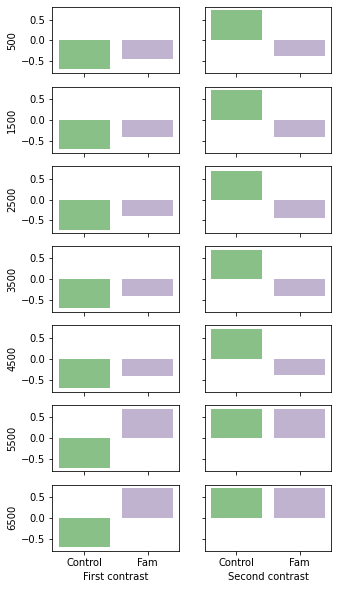

In [75]:
fig, axes = plt.subplots(7,2, figsize=(5,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    contrasts = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_contrasts.csv')
    contrasts = contrasts.rename(columns={"group_Control": "Control",
                                          "group_Fam": "Fam"})
    for j in range(2):
        upls.plot_contrasts(df_data=contrasts, index=j, ax=axes[i][j], palette='Accent')
        axes[i][j].set_xlabel(['First contrast',
                                  'Second contrast'][j]) if i == 6 else axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel(thresholds[i]) if j == 0 else axes[i][j].set_ylabel('')


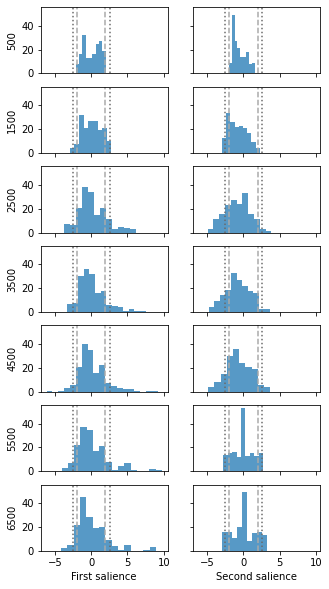

In [84]:
fig, axes = plt.subplots(7,2, figsize=(5,10), sharex=True, sharey=True)
plt.rcParams['patch.edgecolor'] = 'none'
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    for j in range(2):
        sns.histplot(saliences.T[j], ax=axes[i][j])
        axes[i][j].axvline(x=1.96, linestyle='--', color='darkgrey')
        axes[i][j].axvline(x=-1.96, linestyle='--', color='darkgrey')
        axes[i][j].axvline(x=2.56, linestyle=':', color='dimgrey')
        axes[i][j].axvline(x=-2.56, linestyle=':', color='dimgrey')
        axes[i][j].set_xlabel(['First salience',
                                  'Second salience',
                                  'Third salience'][j])    
        if j==0:
            axes[i][j].set_ylabel(thresholds[i])

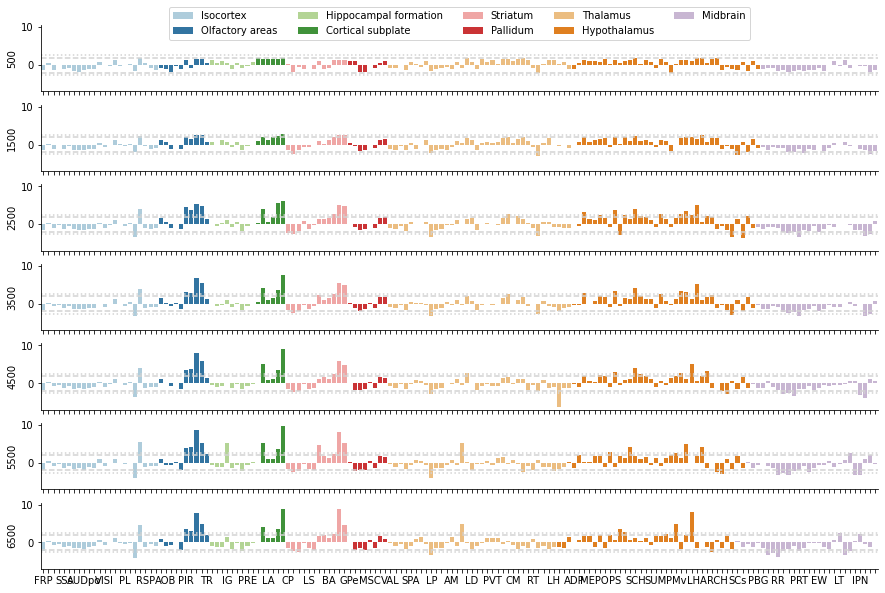

In [99]:
df_levels = upls.create_df_levels(volumes)
fig, axes = plt.subplots(7,1, figsize=(15,10), sharex=True, sharey=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=0, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=-1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=2.56, linestyle=':', color='lightgrey')
    axes[i].axhline(y=-2.56, linestyle=':', color='lightgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
axes[0].legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.35),
ncol=5)

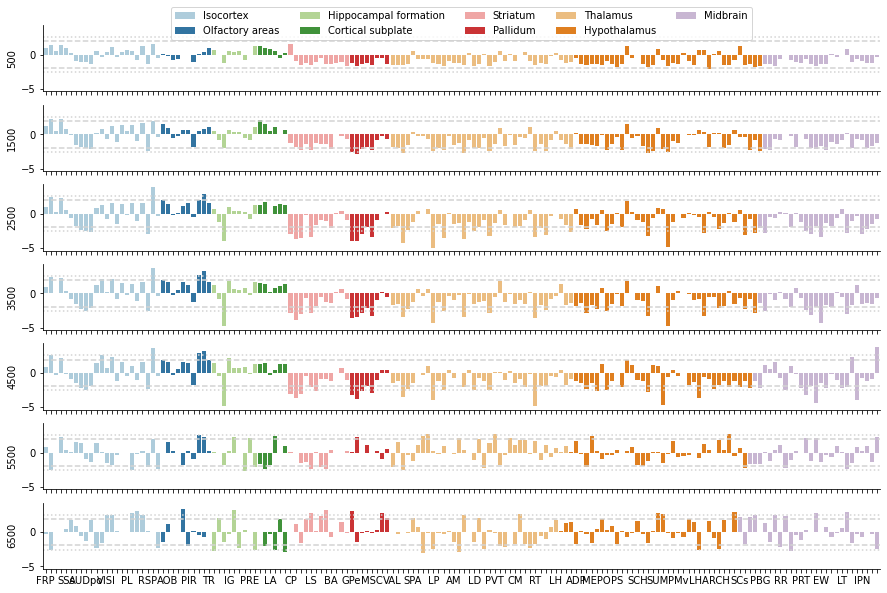

In [100]:
df_levels = upls.create_df_levels(volumes)
fig, axes = plt.subplots(7,1, figsize=(15,10), sharey=True, sharex=True)
for i in range(len(thresholds)):
    saliences = pd.read_csv('./results_pls/'+ 'BL_wf_WholeBrain'+str(thresholds[i])+\
                            '_relative_density_saliences.csv')
    upls.plot_saliences(df_data=saliences, df_levels=df_levels, 
                        index=1, ax=axes[i], palette='Paired')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(thresholds[i])
    if i!=0:
        axes[i].get_legend().remove()
    sns.despine(left=False, bottom=False)
    n = 4  # Keeps every 7th label
    axes[i].axhline(y=1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=-1.96, linestyle='--', color='lightgrey')
    axes[i].axhline(y=2.56, linestyle=':', color='lightgrey')
    axes[i].axhline(y=-2.56, linestyle=':', color='lightgrey')
    [l.set_visible(False) for (i,l) in enumerate(axes[i].xaxis.get_ticklabels()) if i % n != 0]
axes[0].legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.35),
ncol=5)